In [1]:
import math
from typing import Tuple, Any

import matplotlib.pyplot as plt
import numpy as np
import numpy.typing as npt
from commpy.filters import rrcosfilter
from scipy import signal

from comms_freq_sync_py import costas_loop, coarse_freq_correction_psk

%matplotlib widget

In [2]:
# this part came from pulse shaping exercise
num_symbols = 100
sps = 8
bits = np.random.randint(0, 2, num_symbols) # Our data to be transmitted, 1's and 0's
pulse_train = np.array([])
for bit in bits:
    pulse = np.zeros(sps)
    pulse[0] = bit*2-1 # set the first value to either a 1 or -1
    pulse_train = np.concatenate((pulse_train, pulse)) # add the 8 samples to the signal

# Create our raised-cosine filter
num_taps = 101
beta = 0.35
Ts = sps # Assume sample rate is 1 Hz, so sample period is 1, so *symbol* period is 8
t = np.arange(-51, 52) # remember it's not inclusive of final number
h = np.sinc(t/Ts) * np.cos(np.pi*beta*t/Ts) / (1 - (2*beta*t/Ts)**2)

# Filter our signal, in order to apply the pulse shaping
samples = np.convolve(pulse_train, h)

# Create and apply fractional delay filter
delay = 0.4 # fractional delay, in samples
N = 21 # number of taps
n = np.arange(-N//2, N//2) # ...-3,-2,-1,0,1,2,3...
h = np.sinc(n - delay) # calc filter taps
h *= np.hamming(N) # window the filter to make sure it decays to 0 on both sides
h /= np.sum(h) # normalize to get unity gain, we don't want to change the amplitude/power
samples = np.convolve(samples, h) # apply filter

In [3]:
# apply a freq offset
fs = 1e6 # assume our sample rate is 1 MHz
fo = 13000 # simulate freq offset
Ts = 1/fs # calc sample period
t = np.arange(0, Ts*len(samples), Ts) # create time vector
samples = samples * np.exp(1j*2*np.pi*fo*t) # perform freq shift

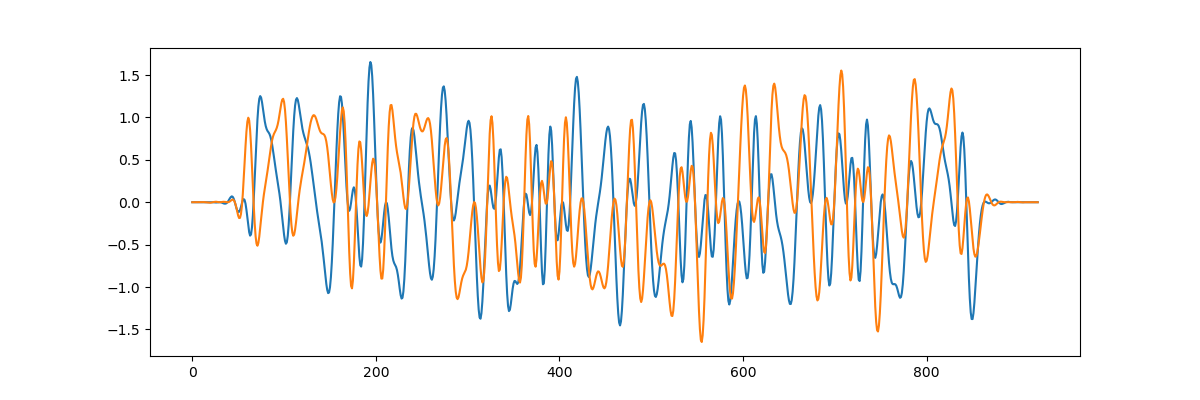

In [4]:
plt.figure(figsize=(12, 4))
plt.plot(np.real(samples))
plt.plot(np.imag(samples))

Freq offset: 57617.1875


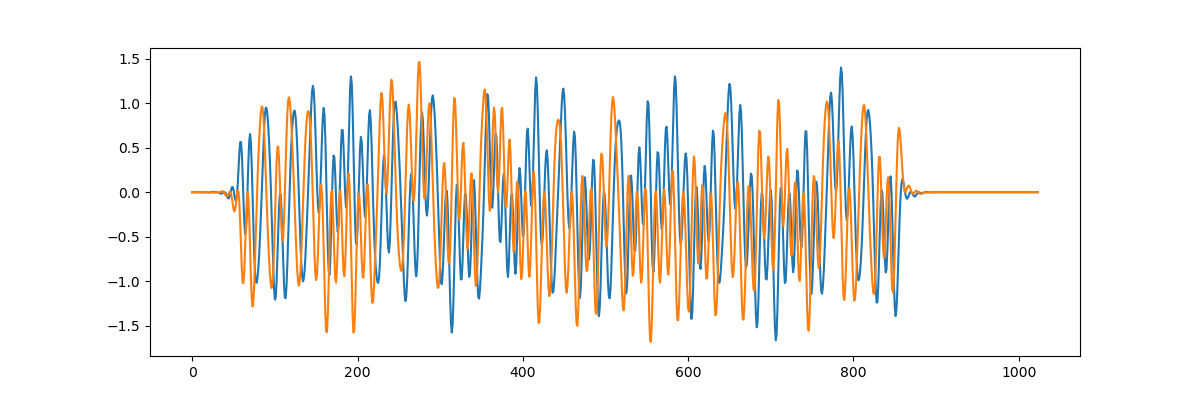

In [5]:
next_p2 = 2**int(np.ceil(np.log2(samples.size)))
coarse_freq_corr, freq_offset = coarse_freq_correction_psk(np.pad(samples, (0, next_p2 - samples.size)), fs, 1)

print(f"Freq offset: {freq_offset}")

plt.figure(figsize=(12, 4))
plt.plot(np.real(coarse_freq_corr))
plt.plot(np.imag(coarse_freq_corr))

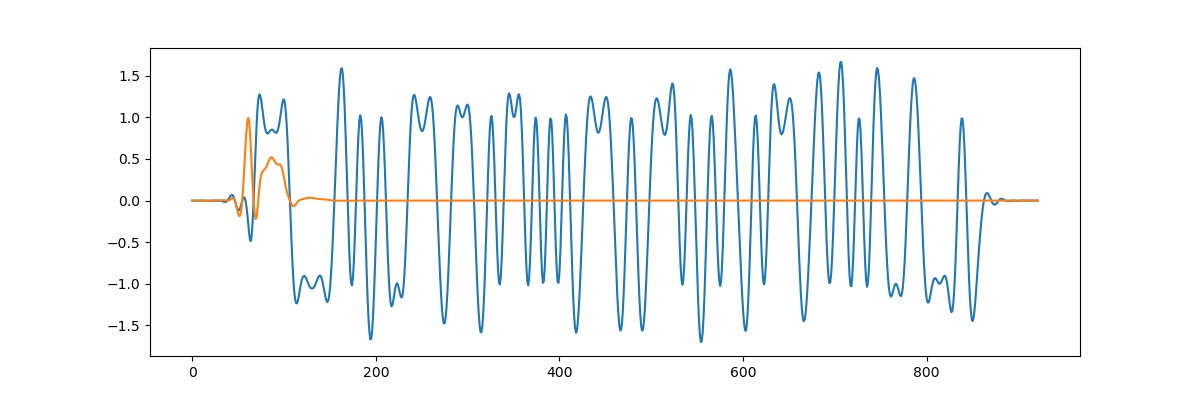

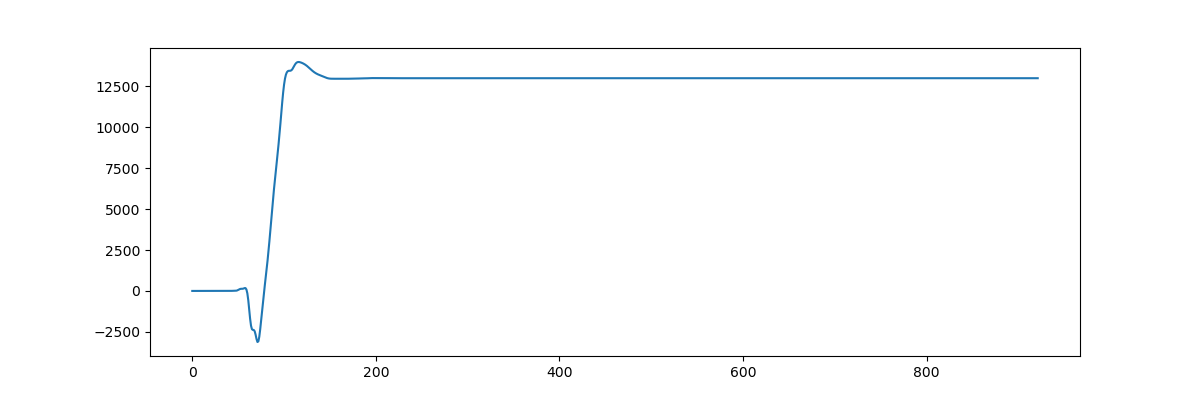

In [6]:
alpha = 0.132
beta = 0.00932

fine_freq_corr, freq_log = costas_loop(samples, fs, alpha, beta)

plt.figure(figsize=(12, 4))
plt.plot(np.real(fine_freq_corr))
plt.plot(np.imag(fine_freq_corr))

plt.figure(figsize=(12, 4))
plt.plot(freq_log)